In [1]:
""" 
Code hiding:
http://blog.nextgenetics.net/?e=102
"""
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
%matplotlib nbagg
import ipywidgets as ipw
import matplotlib.pyplot as plt

from IPython.display import display
from pathlib import Path

import functions as fn

pulses = None
files = None
f = None

In [3]:
def enable_controls():
    ctrl_min_pulse.disabled = False
    ctrl_max_pulse.disabled = False
    btn_plot_mean.disabled = False

def on_max_pulse_change(value):
    if value['new'] < ctrl_min_pulse.value:
        ctrl_max_pulse.value = ctrl_min_pulse.value
    elif value['new'] > ctrl_n_pulses.value:
        ctrl_max_pulse.value = ctrl_n_pulses.value
 
def on_min_pulse_change(value):
    if value['new'] < 1:
        ctrl_min_pulse.value = 1
    elif value['new'] > ctrl_max_pulse.value:
        ctrl_min_pulse.value = ctrl_max_pulse.value  

def on_path_change(value):
    global files
    global f
    path = Path(value['new'])
    files = sorted(path.glob('*.h5'))
    f = sorted([a.name for a in files])
    if len(f) > 0:
        ctrl_file.options = f
        ctrl_file.disabled = False
        btn_select.disabled = False
    else:
        ctrl_file.options = []
        ctrl_file.disabled = True
        btn_select.disabled = True

def plot_mean_profile(b):
    plt.clf()
    plt.plot(fn.get_mean_profile(pulses[ctrl_min_pulse.value - 1:ctrl_max_pulse.value]))
    plt.show()
        
def read_data(b):
    global pulses
    to_read = files[f.index(ctrl_file.value)]
    pulses = fn.read_data(to_read)
    ctrl_n_pulses.value = pulses.shape[0]
    ctrl_n_bins.value = pulses.shape[1]
    
    enable_controls()
    
    ctrl_max_pulse.value = ctrl_n_pulses.value
    ctrl_min_pulse.value = 1
    
ctrl_path = ipw.Text(
    placeholder='Path to data directory',
    description='Path:',
    disabled=False
)

ctrl_file = ipw.Dropdown(
    options=[],
    description='Select file:',
    disabled=True
)

btn_select = ipw.Button(
    description='Accept',
    disabled=True

)

ctrl_n_pulses = ipw.IntText(
    description='Number of pulses',
    disabled=True,
    value = 0
)

ctrl_n_bins = ipw.IntText(
    description='Binning',
    disabled=True,
    value=0
)

ctrl_min_pulse = ipw.IntText(
    description='From:',
    disabled=True,
    value=1
)

ctrl_max_pulse = ipw.IntText(
    description='To:',
    disabled=True,
    value=1
)

btn_plot_mean = ipw.Button(
    description='Plot mean profile',
    disabled=True
)

<IPython.core.display.Javascript object>


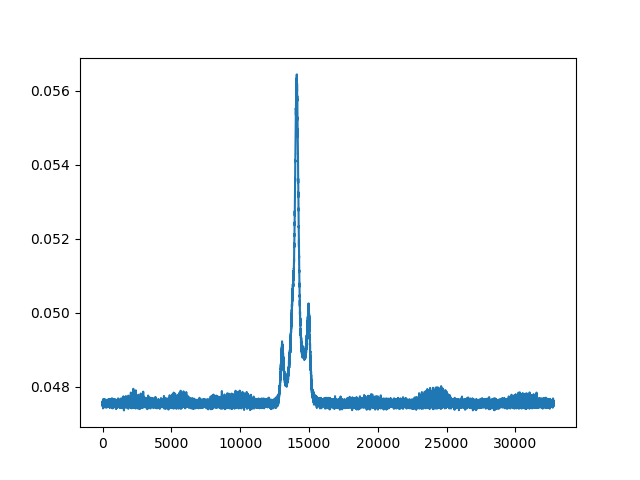

In [4]:
# events handling
ctrl_path.observe(on_path_change, names='value')
btn_select.on_click(read_data)
ctrl_max_pulse.observe(on_max_pulse_change, names='value')
ctrl_min_pulse.observe(on_min_pulse_change, names='value')
btn_plot_mean.on_click(plot_mean_profile)

#layout
l1 = ipw.HBox([ctrl_path, ctrl_file, btn_select])
l2 = ipw.HBox([ctrl_n_pulses, ctrl_n_bins])
l3 = ipw.HBox([ctrl_min_pulse, ctrl_max_pulse, btn_plot_mean])
ipw.VBox([l1, l2, l3])
